In [13]:
#Fetch our league data
from espn_api.football import League

# Initialize your league
league_id = 26347
espn_s2 = 'AECJTHUB5QQ41P4C5vinQpk7fGVA6h%2BnbM7tsN7mhlpWupwMWzVIKnKFd219nyX3Ss37wALT0z0fYoIOd9zieRZOE6I3nG%2BSSEUksFfA43gw8Hv3ywuj9PXh1fTxJlA9O%2FPfzY9GgfQH1OwPqQsmvWx0Zt7YOZKaBvy1ORbTZfgMfOZCVkqNYWMpBZzHCzAun99t%2FS3i24onjEXOch2vI9E%2Ff4y5%2BRBiE%2BaPaOlfnMTy1d3DbG1E%2FYqnZzNWbT3Yk3%2FFq7cLHbHTL1HF4Ouvgf6N'
swid = '{C3FE8278-A2E3-4D18-86D2-0154124A1F16}'
year = 2023  # Replace with the specific year you want

# Initialize the league for the specific year
league = League(league_id=league_id, year=year, espn_s2=espn_s2, swid=swid, debug=False)


In [14]:
# Pull all matchups
matchup_scores = []

# Iterate through each week
for week in range(1, league.current_week + 1):
    # Get the box scores for the current week
    box_scores = league.box_scores(week)

    # Iterate through each game in the box scores
    for game_id, game in enumerate(box_scores, start=1):
        home_team = game.home_team
        away_team = game.away_team

        # Retrieve the scores for each team in the game
        home_score = game.home_score
        away_score = game.away_score

        # Additional information
        season = year
        home_projected = game.home_projected
        away_projected = game.away_projected 

        matchup_info = {
            "game_id": game_id,
            "season": season,
            "week": week,
            "home_team": home_team.team_name,
            "home_team_id": home_team.team_id,
            "home_score": home_score,
            "away_team": away_team.team_name,
            "away_team_id": away_team.team_id,
            "away_score": away_score,
            "home_projected": home_projected,
            "away_projected": away_projected,
        }

        matchup_scores.append(matchup_info)

# Now, matchup_scores contains information about scores, season, projections, and other details for each matchup in every week


In [26]:
#Data cleaning and column creation
import pandas as pd
matchups_df = pd.DataFrame(matchup_scores)
# Add the "home_team_win" label to the DataFrame based on the condition
matchups_df['home_team_win'] = (matchups_df['home_score'] > matchups_df['away_score']).astype(int)
matchups_df['winner_id'] = matchups_df.apply(lambda row: row['home_team_id'] if row['home_team_win'] == 1 else row['away_team_id'], axis=1)
matchups_df = matchups_df[matchups_df['home_score'] != 0]
matchups_df['matchup_id'] =  matchups_df['season'].astype(str) + matchups_df['week'].astype(str) + matchups_df['game_id'].astype(str)
#set matchup_id as index
matchups_df.set_index('matchup_id', inplace=True)
matchups_df.head()

,game_id,season,week,home_team,home_team_id,home_score,away_team,away_team_id,away_score,home_projected,away_projected,home_team_win,winner_id
matchup_id,,,,,,,,,,,,,
202311,1,2023,1,Team SOOO GOOD,9,85.0,Team Gibson,4,116.0,97.55,95.77,0,4
202312,2,2023,1,Gastropod Gunmen,8,80.0,The U23 Bobby Football Team,6,59.0,89.23,91.24,1,8
202313,3,2023,1,Monty Men,1,91.0,Jack's Krevice,3,89.0,87.58,96.32,1,1
202314,4,2023,1,Team LoSardo,2,75.0,DA LOVE DOCTER,5,71.0,95.08,87.05,1,2
202315,5,2023,1,Team Gibsin,10,52.0,Demarco Murray,7,95.0,98.54,94.69,0,7


In [27]:
#Create a historical standings table

# Create an empty DataFrame to store the standings
standings_df = pd.DataFrame()

# Get a list of all unique team IDs
team_ids = matchups_df['home_team_id'].unique()

# Determine the maximum number of weeks in the dataset
max_week = matchups_df['week'].max()

# Iterate through each team
for team_id in team_ids:
    # Create a DataFrame for the current team with all weeks' statistics
    team_df = pd.DataFrame({
        'team_id': [team_id] * max_week,
        'prior_to_week': list(range(1, max_week + 1)),
        'wins': 0,
        'losses': 0,
        'points_for': 0,
        'points_against': 0,
        'win_percentage': 0,
        'points_per_game': 0,
        'points_against_per_game': 0
    })

    # Iterate through each week
    for week in range(1, max_week + 1):
        # Filter the DataFrame to get data prior to the current week
        prior_to_week_df = matchups_df[matchups_df['week'] < week]

        # Filter the DataFrame to get matches involving the current team
        team_matches = prior_to_week_df[(prior_to_week_df['home_team_id'] == team_id) | (prior_to_week_df['away_team_id'] == team_id)]

        # Calculate team statistics
        team_wins = sum(team_matches['home_team_id'] == team_id)
        team_losses = sum(team_matches['away_team_id'] == team_id)
        team_points_for = sum(team_matches.loc[team_matches['home_team_id'] == team_id, 'home_score']) + sum(team_matches.loc[team_matches['away_team_id'] == team_id, 'away_score'])
        team_points_against = sum(team_matches.loc[team_matches['home_team_id'] == team_id, 'away_score']) + sum(team_matches.loc[team_matches['away_team_id'] == team_id, 'home_score'])
        total_games = team_wins + team_losses
        win_percentage = team_wins / total_games if total_games > 0 else 0
        points_per_game = team_points_for / total_games if total_games > 0 else 0
        points_against_per_game = team_points_against / total_games if total_games > 0 else 0

        # Update the current week's statistics in the team's DataFrame
        team_df.loc[week - 1, 'wins'] = team_wins
        team_df.loc[week - 1, 'losses'] = team_losses
        team_df.loc[week - 1, 'points_for'] = team_points_for
        team_df.loc[week - 1, 'points_against'] = team_points_against
        team_df.loc[week - 1, 'win_percentage'] = win_percentage
        team_df.loc[week - 1, 'points_per_game'] = points_per_game
        team_df.loc[week - 1, 'points_against_per_game'] = points_against_per_game

    # Append the team's DataFrame to the standings DataFrame
    standings_df = pd.concat([standings_df, team_df], ignore_index=True)

In [28]:
# Merge historical standings into matchup data to get team stats prior to each matchup

# Merge 'standings_df' into 'df' for home team's statistics
matchups_df = pd.merge(matchups_df, standings_df, how='left', left_on=['home_team_id', 'week'], right_on=['team_id', 'prior_to_week'])

# Rename the columns for home team's statistics
matchups_df = matchups_df.rename(columns={
    'win_percentage': 'home_team_win_pct',
    'points_per_game': 'home_team_ppg'
})

# Drop the redundant columns from the merge
matchups_df = matchups_df.drop(['team_id', 'prior_to_week', 'wins', 'losses', 'points_for', 'points_against', 'points_against_per_game'], axis=1)

# Merge 'standings_df' into 'df' for away team's statistics
matchups_df = pd.merge(matchups_df, standings_df, how='left', left_on=['away_team_id', 'week'], right_on=['team_id', 'prior_to_week'])

# Rename the columns for away team's statistics
matchups_df = matchups_df.rename(columns={
    'win_percentage': 'away_team_win_pct',
    'points_per_game': 'away_team_ppg'
})

# Drop the redundant columns from the merge
matchups_df = matchups_df.drop(['team_id', 'prior_to_week', 'wins', 'losses', 'points_for', 'points_against', 'points_against_per_game'], axis=1)

# Print the updated 'df' DataFrame
matchups_df.head(30)

,game_id,season,week,home_team,home_team_id,home_score,away_team,away_team_id,away_score,home_projected,away_projected,home_team_win,winner_id,home_team_win_pct,home_team_ppg,away_team_win_pct,away_team_ppg
0,1,2023,1,Team SOOO GOOD,9,85.0,Team Gibson,4,116.0,97.55,95.77,0,4,0.000000,0.000000,0.000000,0.000000
1,2,2023,1,Gastropod Gunmen,8,80.0,The U23 Bobby Football Team,6,59.0,89.23,91.24,1,8,0.000000,0.000000,0.000000,0.000000
2,3,2023,1,Monty Men,1,91.0,Jack's Krevice,3,89.0,87.58,96.32,1,1,0.000000,0.000000,0.000000,0.000000
3,4,2023,1,Team LoSardo,2,75.0,DA LOVE DOCTER,5,71.0,95.08,87.05,1,2,0.000000,0.000000,0.000000,0.000000
4,5,2023,1,Team Gibsin,10,52.0,Demarco Murray,7,95.0,98.54,94.69,0,7,0.000000,0.000000,0.000000,0.000000
5,1,2023,2,Team Gibson,4,147.0,DA LOVE DOCTER,5,74.0,100.70,88.77,1,4,0.000000,116.000000,0.000000,71.000000
6,2,2023,2,Gastropod Gunmen,8,61.0,Team SOOO GOOD,9,95.0,85.64,99.45,0,9,1.000000,80.000000,1.000000,85.000000
7,3,2023,2,Monty Men,1,82.0,The U23 Bobby Football Team,6,118.0,95.10,92.78,0,6,1.000000,91.000000,0.000000,59.000000
8,4,2023,2,Team LoSardo,2,85.0,Demarco Murray,7,110.0,97.32,97.57,0,7,1.000000,75.000000,0.000000,95.000000
9,5,2023,2,Team Gibsin,10,103.0,Jack's Krevice,3,89.0,91.53,93.49,1,10,1.000000,52.000000,0.000000,89.000000


In [29]:
matchups_df.dtypes

game_id                int64
season                 int64
week                   int64
home_team             object
home_team_id           int64
home_score           float64
away_team             object
away_team_id           int64
away_score           float64
home_projected       float64
away_projected       float64
home_team_win          int64
winner_id              int64
home_team_win_pct    float64
home_team_ppg        float64
away_team_win_pct    float64
away_team_ppg        float64
dtype: object

In [59]:
from sklearn.model_selection import train_test_split

# Specify the features and target variable
X = matchups_df.drop(columns=['home_team_win','winner_id','home_team','away_team','away_score','home_score','home_team_id','away_team_id','game_id'])  # Replace 'target_column' with the name of your target variable
y = matchups_df['home_team_win']

# Split the data into training and test sets (e.g., 80% train and 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [62]:
import xgboost as xgb
from sklearn.metrics import log_loss, brier_score_loss

# Create an XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Fit the classifier to the training data
xgb_classifier.fit(X_train, y_train)

# Calculate accuracy on training and test data
train_accuracy = xgb_classifier.score(X_train, y_train)
test_accuracy = xgb_classifier.score(X_test, y_test)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get probability estimates for both training and test data
y_train_prob = xgb_classifier.predict_proba(X_train)
y_test_prob = xgb_classifier.predict_proba(X_test)

# Calculate log loss on training and test data
train_log_loss = log_loss(y_train, y_train_prob)
test_log_loss = log_loss(y_test, y_test_prob)
print(f"Training Log Loss: {train_log_loss:.4f}")
print(f"Test Log Loss: {test_log_loss:.4f}")

# Calculate Brier score on training and test data
train_brier_score = brier_score_loss(y_train, y_train_prob[:, 1])  # Use probability of the positive class
test_brier_score = brier_score_loss(y_test, y_test_prob[:, 1])
print(f"Training Brier Score: {train_brier_score:.4f}")
print(f"Test Brier Score: {test_brier_score:.4f}")

Training Accuracy: 1.0000
Test Accuracy: 0.5000
Training Log Loss: 0.1049
Test Log Loss: 1.7694
Training Brier Score: 0.0155
Test Brier Score: 0.4767


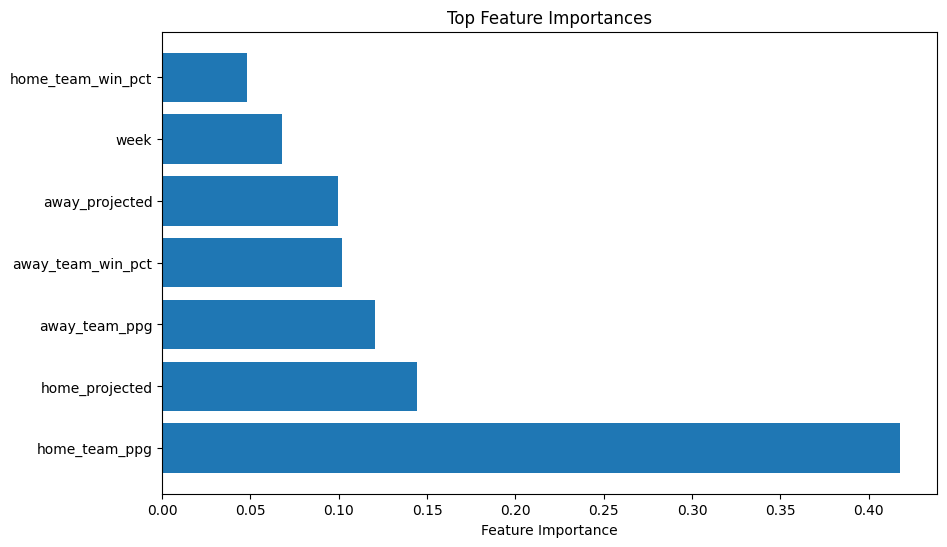

In [56]:
feature_importances = xgb_classifier.feature_importances_

# Get the names of the features
feature_names = X_train.columns

# Create a DataFrame to display the feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the top N most important features
N = 7  # Change N to the number of top features you want to display
top_features = importance_df.head(N)


import matplotlib.pyplot as plt
# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(N), top_features['Importance'], align='center')
plt.yticks(range(N), top_features['Feature'])
plt.xlabel('Feature Importance')
plt.title('Top Feature Importances')
plt.show()

Training Accuracy: 1.0000
Test Accuracy: 0.5000
Training Brier Score: 0.0000
Test Brier Score: 0.5000
Top Features:
                 Feature  Importance
5          home_team_ppg    0.603810
8     home_team_win_pred    0.188235
9  home_team_win_correct    0.107563
2         home_projected    0.100392
0                 season    0.000000


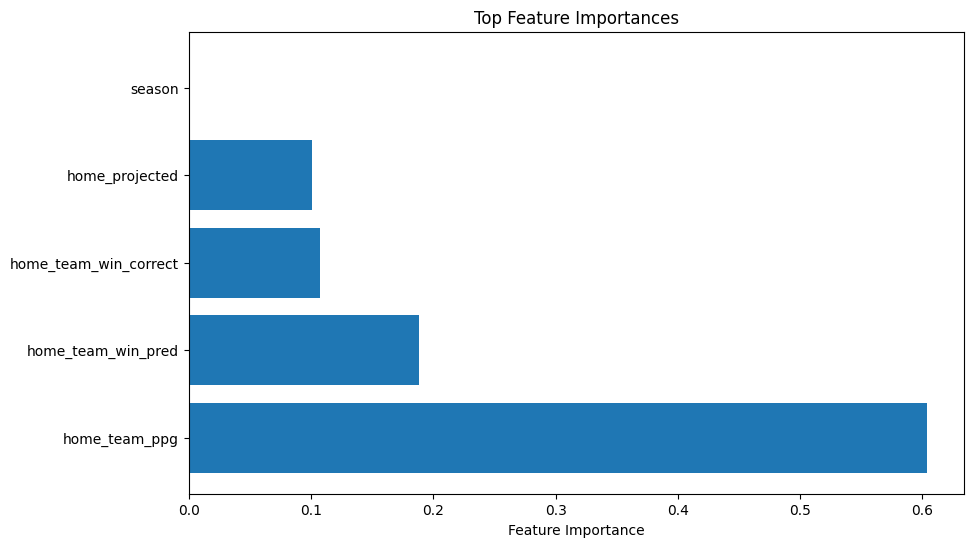

In [64]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, log_loss, brier_score_loss
import matplotlib.pyplot as plt

# Create a Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Fit the classifier to the training data
dt_classifier.fit(X_train, y_train)

# Calculate accuracy on training and test data
y_train_pred = dt_classifier.predict(X_train)
y_test_pred = dt_classifier.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get probability estimates for both training and test data
y_train_prob = dt_classifier.predict_proba(X_train)
y_test_prob = dt_classifier.predict_proba(X_test)

# DecisionTreeClassifier does not natively provide probability estimates, so we will use predict_proba with a simple workaround
# Calculate log loss on training and test data
# Decision trees can only provide probability estimates in scikit-learn if `max_depth` is set, but this is not recommended as it may lead to overfitting
# As a result, log loss cannot be calculated for DecisionTreeClassifier

# Calculate Brier score on training and test data
train_brier_score = brier_score_loss(y_train, y_train_prob[:, 1])  # Use probability of the positive class
test_brier_score = brier_score_loss(y_test, y_test_prob[:, 1])

print(f"Training Brier Score: {train_brier_score:.4f}")
print(f"Test Brier Score: {test_brier_score:.4f}")

# DecisionTreeClassifier does not natively provide probability estimates, so Brier score is used here

# Plot feature importances (similar to XGBoost)
feature_importances = dt_classifier.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

N = 5  # Change N to the number of top features you want to display
top_features = importance_df.head(N)

print("Top Features:")
print(top_features)

plt.figure(figsize=(10, 6))
plt.barh(range(N), top_features['Importance'], align='center')
plt.yticks(range(N), top_features['Feature'])
plt.xlabel('Feature Importance')
plt.title('Top Feature Importances')
plt.show()


In [57]:
# Baseline Model Using ESPN Projections
def baseline_pred(dataset):
    #if home team has higher projection, predict home team win
    dataset['home_team_win_pred'] = (dataset['home_projected'] > dataset['away_projected']).astype(int)
    #check accuracy of baseline model
    dataset['home_team_win'] = (dataset['home_score'] > dataset['away_score']).astype(int)
    dataset['home_team_win_correct'] = (dataset['home_team_win'] == dataset['home_team_win_pred']).astype(int)
    baseline_accuracy = dataset['home_team_win_correct'].mean()
    print(f"Baseline accuracy: {baseline_accuracy:.4f}")
    

baseline_pred(matchups_df)

Baseline accuracy: 0.5750
